In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import re
import sys
import time
import logging
import tempfile
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles

import deepchem as dc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from scipy.sparse import csr_matrix, lil_matrix

import atomInSmiles as ais
import json

In [2]:
# This vocab only focus in characters not in pairs.
class CreateVocab:
    def __init__(self, datasets):
        """
        Initialize the CreateVocab object with multiple datasets.

        :param datasets: List of datasets (strings) to build the vocabulary from.
        """
        self.stoi = {}
        self.itos = {}
        self.build_vocab(datasets)

    def build_vocab(self, datasets):
        """
        Builds the vocabulary from the given datasets.

        :param datasets: List of datasets (strings) to build the vocabulary from.
        """
        all_text = ''.join(datasets)  # Concatenate all datasets
        unique_chars = sorted(set(all_text))  # Extract unique characters

        self.stoi = {char: idx for idx, char in enumerate(unique_chars)}
        self.itos = {idx: char for idx, char in enumerate(unique_chars)}

    def encode(self, text):
        """
        Encodes a given text into a list of indices.

        :param text: String to be encoded.
        :return: List of indices corresponding to the characters in the text.
        """
        return [self.stoi[char] for char in text]

    def decode(self, indices):
        """
        Decodes a list of indices into a string.

        :param indices: List of indices to be decoded.
        :return: Decoded string.
        """
        return ''.join(self.itos[idx] for idx in indices)


def preprocess_smiles(smiles):
    """
    Preprocesses a given SMILES string by adding padding and start and end tokens.

    :param smiles: SMILES string to be preprocessed.
    :return: Preprocessed SMILES string.
    """
    text = [str(i) + "*" for i in smiles]
    text = str(text)[1:-1]
    return text

# Load and process datasets
smile_1 = pd.read_csv('smile_1.csv')['smiles']
smile_2 = pd.read_csv('smile_2.csv')['smiles']
smile_3 = pd.read_csv('smile_3.csv')['canonical_smiles']

processed_smile_1 = preprocess_smiles(smile_1)
processed_smile_2 = preprocess_smiles(smile_2)
processed_smile_3 = preprocess_smiles(smile_3)

# Combine processed datasets
combined_text = processed_smile_1 + processed_smile_2 + processed_smile_3

# Create vocabulary
vocab = CreateVocab([combined_text])

# Now vocab.stoi and vocab.itos are your dictionaries



In [103]:
print(vocab.itos)

{0: ' ', 1: '#', 2: '%', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: '=', 23: '@', 24: 'A', 25: 'B', 26: 'C', 27: 'F', 28: 'G', 29: 'H', 30: 'I', 31: 'K', 32: 'L', 33: 'M', 34: 'N', 35: 'O', 36: 'P', 37: 'R', 38: 'S', 39: 'T', 40: 'U', 41: 'V', 42: 'W', 43: 'Z', 44: '[', 45: '\\', 46: ']', 47: 'a', 48: 'b', 49: 'c', 50: 'd', 51: 'e', 52: 'g', 53: 'h', 54: 'i', 55: 'l', 56: 'n', 57: 'o', 58: 'p', 59: 'r', 60: 's', 61: 't', 62: 'u'}


In [4]:
encoded_text = vocab.encode(text)

# Train and test splits
data = torch.tensor(encoded_text, dtype=torch.long)
n = int(0.9 * len(data))  # 90% for training, rest for validation
train_data = data[:n]
val_data = data[n:]

In [5]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 350
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)
vocab_size = len(vocab.stoi)

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [6]:
model = BigramLanguageModel()

In [7]:
model_state_path = "3_BSC.pkl"
model.load_state_dict(torch.load(model_state_path))

<All keys matched successfully>

In [8]:

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.209471 M parameters


In [217]:


train_losses = []
val_losses = []
for iter in range(max_iters):
    # Evaluate the loss periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Get a batch of data
    xb, yb = get_batch('train')

    # Forward pass and loss computation
    logits, loss = model(xb, yb)

    # Backpropagation
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)


step 0: train loss 1.0621, val loss 1.1229
step 10: train loss 0.7725, val loss 1.3258
step 20: train loss 0.6960, val loss 1.3266
step 30: train loss 0.6477, val loss 1.4073
step 40: train loss 0.6119, val loss 1.3961
step 50: train loss 0.5741, val loss 1.4333
step 60: train loss 0.5560, val loss 1.4377
step 70: train loss 0.5273, val loss 1.4105
step 80: train loss 0.5214, val loss 1.4221
step 90: train loss 0.5027, val loss 1.4055
step 100: train loss 0.4805, val loss 1.4365
step 110: train loss 0.4777, val loss 1.5263
step 120: train loss 0.4632, val loss 1.4988
step 130: train loss 0.4541, val loss 1.5192
step 140: train loss 0.4542, val loss 1.5889
step 150: train loss 0.4251, val loss 1.5367
step 160: train loss 0.4367, val loss 1.5615
step 170: train loss 0.4200, val loss 1.5790
step 180: train loss 0.4108, val loss 1.5951
step 190: train loss 0.3917, val loss 1.6626
step 200: train loss 0.3850, val loss 1.6032
step 210: train loss 0.3848, val loss 1.6098
step 220: train loss 

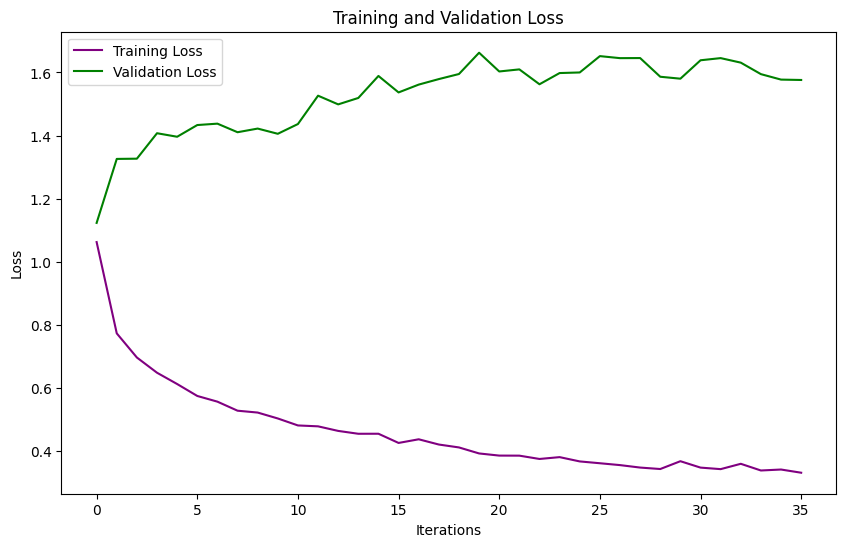

In [218]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='purple')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [3]:
smiles_1 = pd.read_csv('smile_3.csv')
smiles_1 = smiles_1['canonical_smiles']
text = [str(i) + "*" for i in smiles_1]
text = str(text)[1:-1]
text = text.replace('(', ' (').replace(')', ') ').replace('[', ' [').replace(']', '] ')


In [107]:
print(len(text))

15420651


In [9]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)


In [17]:
val = vocab.decode(m.generate(context, max_new_tokens=2000)[0].tolist())

In [18]:
print(val)

 [C@@H]  (Cc1ccccc1Cl) NC (=O) c1ccccc1) S (=O)  (=O) c1cccc2c (c1) 2c (c1ccccc1) S (=O)  (=O) c1cccncn1) S (=O)  (=O) cc1ncc12) S (=O)  (=O) c1ccc (N) ccc1*', 'CC (Cc1ccccc1) S (=O)  (=O) c1cccc (N) cc1*', 'O=C (C) CN ( [C@H]  (CO) CCCCNNC (=O)  [C@H]  (Cc1ccncc12O) C (=O) N [C@@H] C (c1ccc1Br) N (CC (=O) N [C@H]  (CO) CCCCNNC (=O)  [C@H]  (Cc1ccc2cccccc2Br) c1O2) O2*', 'Cc1cc2cncscn1C (=O) N [C@H]  (Cc1ccc2ccccc1) C (=O) S (=O)(=O) c1c (c1cc (N) cc1*', 'CC (C) CN ( [C@@H]  (CO) CCCCNC (=O)  [C@H]  (Cc1cccc2ccccc12c1) NC (=O) N1Cc1cccccc1) S (=O)  (=O) c1ccc (N) ccc1) C [C@@H]  (NC (=O) c1ccc (N) cc1) cc1ccccc1*', 'CS (=O)   (=O) c1ccc2c (c1ccc2c (c1) CO2*', 'Cc1cccc2C (=O) N [C@@H]  (CO) NN (CC (C) C) S (=O)  (=O) c1ccc2c (c12) CCO21) C (N) CCO2*', 'Cc1 (C (=O) OC (=O) N [C@H]  (Cn1) OC (=O) c1ccoc1) O2=O2) oc (C) c3ccc (O) n12) OCO2*', 'CC (C) CNS (=O)  (=O) c1cccc (N) cc1*', 'CC (C) CN (C) CCN (SO)  (=O) c1c (N) ccc2c1) S (=O)  (=O) c1cc (oc1) OCC (=O) N1COCCN1*', 'CC (C) CN ( [C@H

In [19]:
molecules = list(val.split(","))
molecules = [i.replace("*", "") for i in molecules]
molecules = [i.replace("'", "") for i in molecules]
molecules = [i.replace(" ", "") for i in molecules]
molecules = [i.replace("\\n", "") for i in molecules]
#molecules = [i.replace("\\", "") for i in molecules]

print(molecules)

['[C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1', 'CC(Cc1ccccc1)S(=O)(=O)c1cccc(N)cc1', 'O=C(C)CN([C@H](CO)CCCCNNC(=O)[C@H](Cc1ccncc12O)C(=O)N[C@@H]C(c1ccc1Br)N(CC(=O)N[C@H](CO)CCCCNNC(=O)[C@H](Cc1ccc2cccccc2Br)c1O2)O2', 'Cc1cc2cncscn1C(=O)N[C@H](Cc1ccc2ccccc1)C(=O)S(=O)(=O)c1c(c1cc(N)cc1', 'CC(C)CN([C@@H](CO)CCCCNC(=O)[C@H](Cc1cccc2ccccc12c1)NC(=O)N1Cc1cccccc1)S(=O)(=O)c1ccc(N)ccc1)C[C@@H](NC(=O)c1ccc(N)cc1)cc1ccccc1', 'CS(=O)(=O)c1ccc2c(c1ccc2c(c1)CO2', 'Cc1cccc2C(=O)N[C@@H](CO)NN(CC(C)C)S(=O)(=O)c1ccc2c(c12)CCO21)C(N)CCO2', 'Cc1(C(=O)OC(=O)N[C@H](Cn1)OC(=O)c1ccoc1)O2=O2)oc(C)c3ccc(O)n12)OCO2', 'CC(C)CNS(=O)(=O)c1cccc(N)cc1', 'CC(C)CN(C)CCN(SO)(=O)c1c(N)ccc2c1)S(=O)(=O)c1cc(oc1)OCC(=O)N1COCCN1', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](CCc1ccc2c1cccccc1Br)S(=O)(=O)c1ccc(N)cc1)c1ccOc1cccccc1)S(=O)(=O)c1ccc(N)ccc1)OC(CF)(N)cc1)C(=O)NCc1cccc1', 'CC(C)CN((CC(C)CCCNC(=O)[C@H](Cc1ccccc1Br)C(CN=C1)NC(=O)c1cc(c1)cc1cccc

In [20]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


mols = [Chem.MolFromSmiles(smi) for smi in molecules if Chem.MolFromSmiles(smi) is not None]
mols
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in range(len(mols))])

[05:20:25] SMILES Parse Error: extra close parentheses while parsing: [C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1
[05:20:25] SMILES Parse Error: Failed parsing SMILES '[C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1' for input: '[C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1'
[05:20:25] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19
[05:20:25] SMILES Parse Error: extra open parentheses for input: 'O=C(C)CN([C@H](CO)CCCCNNC(=O)[C@H](Cc1ccncc12O)C(=O)N[C@@H]C(c1ccc1Br)N(CC(=O)N[C@H](CO)CCCCNNC(=O)[C@H](Cc1ccc2cccccc2Br)c1O2)O2'
[05:20:25] SMILES Parse Error: extra open parentheses for input: 'Cc1cc2cncscn1C(=O)N[C@H](Cc1ccc2ccccc1)C(=O)S(=O)(=O)c1c(c1cc(N)cc1'
[05:20:25] SMILES Parse Error: extra close parentheses while parsing: CC(C)CN([C

RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 214 in file Code\GraphMol\MolDraw2D\MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2022.09.5
	BOOST: 1_78


In [219]:
model_state_path = "3_BSC.pkl"
torch.save(model.state_dict(), model_state_path)

print("Model saved successfully.")

Model saved successfully.


In [22]:
# Calculate the valid smiles

from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

# Example dataset loading
# protease_df and nrti_df should already be loaded as shown in your initial step

# Function to check for valid RDKit Mol objects and catch potential syntax errors
new = molecules
def is_valid_for_drawing(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:  # Check if RDKit failed to create a Mol object
            return False
        Chem.SanitizeMol(mol)  # Attempt to sanitize the molecule, catching syntax errors
        return True
    except:  # Catch any exceptions thrown by RDKit (e.g., sanitization errors)
        return False
    
def get_valid_mols(smiles_list):
    valid_mols = []
    for smiles in smiles_list:
        if is_valid_for_drawing(smiles):
            valid_mols.append(smiles)
    return valid_mols


valid_smiles = get_valid_mols(new)
print(f"Number of valid smiles: {len(valid_smiles)}")
#as percentage
print(f"Percentage of valid smiles: {len(valid_smiles)/len(new)*100:.2f}%")

Number of valid smiles: 0
Percentage of valid smiles: 0.00%


[05:20:56] SMILES Parse Error: extra close parentheses while parsing: [C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1
[05:20:56] SMILES Parse Error: Failed parsing SMILES '[C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1' for input: '[C@@H](Cc1ccccc1Cl)NC(=O)c1ccccc1)S(=O)(=O)c1cccc2c(c1)2c(c1ccccc1)S(=O)(=O)c1cccncn1)S(=O)(=O)cc1ncc12)S(=O)(=O)c1ccc(N)ccc1'
[05:20:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19
[05:20:56] SMILES Parse Error: extra open parentheses for input: 'O=C(C)CN([C@H](CO)CCCCNNC(=O)[C@H](Cc1ccncc12O)C(=O)N[C@@H]C(c1ccc1Br)N(CC(=O)N[C@H](CO)CCCCNNC(=O)[C@H](Cc1ccc2cccccc2Br)c1O2)O2'
[05:20:56] SMILES Parse Error: extra open parentheses for input: 'Cc1cc2cncscn1C(=O)N[C@H](Cc1ccc2ccccc1)C(=O)S(=O)(=O)c1c(c1cc(N)cc1'
[05:20:56] SMILES Parse Error: extra close parentheses while parsing: CC(C)CN([C

In [85]:
# Recreate the model architecture
loaded_model = BigramLanguageModel()

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_state_path))

# Switch to evaluation mode if you are using the model for inference
loaded_model.eval()

BigramLanguageModel(
  (token_embedding_table): Embedding(63, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    

In [86]:
val = vocab.decode(loaded_model.generate(context, max_new_tokens=2000)[0].tolist())

In [87]:
print(val)

 S (=O)  (=O) c1ccc (C) c1cccc (N) cc3c (F) Wc1*', 'CC (C) CN ( [C@H]  (CO) CCCCNC (=O)  [C@H]  (Cc3] (CC1=CC) (=O) NCCCCT1) S (=O)  (=O) c1ccc (@H] CCCCCC1) NC (=O) c1cccc2c2c (N) c1CBr) C (=O) NCCCCC [C@@H]  (CO) N (CC (C) S (=O)  (=O) c1ccc (r) c1*', ', 'Cc1ccc (Cl) Z(=O) c1ccc (N) cc1*', 'CCC (=O) N [C@H]  (Cc1ccccc1B) S (=O)  (=O) c1ccc (N) cc1*', 'CC (C) S (=O)  (=O) c1cccc (N) cc2cc (C) c1ccccc1, ) C (=O) NCCCC [C@@@H]  (CO) N (CC (C) S (=O)  (=O) c1O) cc2cc (FZ3[C@@H]  (F) NCCC (=O) NCCCC [C@@H]  (CO) N (CC (C) C) S (=O)  (=O) c1ccc (N) cc1*', 'CC [C@@H]  (C (=O) NCCCC (C) C) S (=O)  (=O) c1ccc2cccn1) C (c1) NCCCO2)  (CO) C1*', 'COCNC (=O) N1CC [C@@H]  (C) ( =O) NCCCCC ([) @H]  (CO) N (CC (C) S (=O)  (=O) c1ccc (N) oc (C (=O) N1CCCCCNC [C@@H]  (C (C) C) N ( (CC) S (=O)  (=O) c1ccc (N) cc12cc (C#N) CCc1cc (N) c1cccc1*', 'C (C) CN ( [C@H]  (CO) CCCCNC (=O)  (CCNC [C@@H]  (Cc1ccccc1Br) NC (=O) NCCCC [C@@H]  (O) N (CC (C) C) S (=O)  (=O) c1ccc2cc ) c1*', 'CCC (=O) N [C@@H]  (C1CCCC

In [74]:

smiles_1 = pd.read_csv('smile_3.csv')
smiles_1 = smiles_1['canonical_smiles']
text = [str(i) + "*" for i in smiles_1]
text = str(text)[1:-1]
text = text.replace('(', ' (').replace(')', ') ').replace('[', ' [').replace(']', '] ')
text

"'CC(C)CN(Sc1ccc2c(c1)CCO2)[C@H](CO)CCCCNC(=O)[C@@H](Cc1cccc2ccccc12)NC(=O)N1CCOCC1*', 'CC(C)CN(Sc1ccc2c(c1)OCCO2)[C@H](CO)CCCCNC(=O)[C@@H](Cc1cccc2ccccc12)NC(=O)N1CCOCC1*', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)N1CCOCC1)S(=O)(=O)c1ccc2c(c1)CCO2*', 'Cc1c(O)cccc1C(=O)N[C@@H](Cc1ccccc1Br)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)c1cccc(=O)[nH]1)S(=O)(=O)c1ccc(N)cc1*', 'Cc1ccccc1C[C@H](NC(=O)c1cccnc1)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'O=C(O)CNC(=O)c1c(=O)oc(O)c2cc(Br)ccc12*', 'C[C@H](NC(=O)c1c(=O)oc(O)c2cccc(-c3cccc(C(F)(F)F)c3)c12)C(=O)O*', 'Cc1ccccc1C[C@H](NC(=O)c1cccc(C)c1O)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'COC(=O)N[C@@H](CC1CCCCC1)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](CC1CCCCC1)NC(=O)c1cccnc1)S(=O)(=O)c1ccc(N)cc1*', 'Cc1ccc(C(=O)N[C@@H](CC2CCCCC2)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c2ccc(N)cc2)cn1*', 'COC(=O)N[C@H](C(=O)

"'CC  (C)  CN  (Sc1ccc2c  (c1)  CCO2)    [C@H]    (CO)  CCCCNC  (=O)    [C@@H]    (Cc1cccc2ccccc12)  NC  (=O)  N1CCOCC1*', 'CC  (C)  CN  (Sc1ccc2c  (c1)  OCCO2)    [C@H]    (CO)  CCCCNC  (=O)    [C@@H]    (Cc1cccc2ccccc12)  NC  (=O)  N1CCOCC1*', 'CC  (C)  CN  (  [C@H]    (CO)  CCCCNC  (=O)    [C@H]    (Cc1ccccc1Br)  NC  (=O)  N1CCOCC1)  S  (=O)    (=O)  c1ccc2c  (c1)  CCO2*', 'Cc1c  (O)  cccc1C  (=O)  N  [C@@H]    (Cc1ccccc1Br)  C  (=O)  NCCCC  [C@@H]    (CO)  N  (CC  (C)  C)  S  (=O)    (=O)  c1ccc  (N)  cc1*', 'CC  (C)  CN  (  [C@H]    (CO)  CCCCNC  (=O)    [C@H]    (Cc1ccccc1Br)  NC  (=O)  c1cccc  (=O)    [nH]  1)  S  (=O)    (=O)  c1ccc  (N)  cc1*', 'Cc1ccccc1C  [C@H]    (NC  (=O)  c1cccnc1)  C  (=O)  NCCCC  [C@@H]    (CO)  N  (CC  (C)  C)  S  (=O)    (=O)  c1ccc  (N)  cc1*', 'O=C  (O)  CNC  (=O)  c1c  (=O)  oc  (O)  c2cc  (Br)  ccc12*', 'C  [C@H]    (NC  (=O)  c1c  (=O)  oc  (O)  c2cccc  (-c3cccc  (C  (F)    (F)  F)  c3)  c12)  C  (=O)  O*', 'Cc1ccccc1C  [C@H]    (NC  (=O)  c1cccc

In [73]:
import re

def join_parentheses(text):
    # Function to remove spaces from a match
    def remove_spaces(match):
        return match.group(0).replace(" ", "")

    # Regular expression to match text within () and []
    pattern = re.compile(r'\([^)]*\)|\[[^\]]*\]')

    # Replace all matches in the text using the remove_spaces function
    return pattern.sub(remove_spaces, text)

text = join_parentheses(text)
print(text)


    

'CC(C)CN(Sc1ccc2c(c1)CCO2)[C@H](CO)CCCCNC(=O)[C@@H](Cc1cccc2ccccc12)NC(=O)N1CCOCC1*', 'CC(C)CN(Sc1ccc2c(c1)OCCO2)[C@H](CO)CCCCNC(=O)[C@@H](Cc1cccc2ccccc12)NC(=O)N1CCOCC1*', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)N1CCOCC1)S(=O)(=O)c1ccc2c(c1)CCO2*', 'Cc1c(O)cccc1C(=O)N[C@@H](Cc1ccccc1Br)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)c1cccc(=O)[nH]1)S(=O)(=O)c1ccc(N)cc1*', 'Cc1ccccc1C[C@H](NC(=O)c1cccnc1)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'O=C(O)CNC(=O)c1c(=O)oc(O)c2cc(Br)ccc12*', 'C[C@H](NC(=O)c1c(=O)oc(O)c2cccc(-c3cccc(C(F)(F)F)c3)c12)C(=O)O*', 'Cc1ccccc1C[C@H](NC(=O)c1cccc(C)c1O)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'COC(=O)N[C@@H](CC1CCCCC1)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1ccc(N)cc1*', 'CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](CC1CCCCC1)NC(=O)c1cccnc1)S(=O)(=O)c1ccc(N)cc1*', 'Cc1ccc(C(=O)N[C@@H](CC2CCCCC2)C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c2ccc(N)cc2)cn1*', 'COC(=O)N[C@H](C(=O)N

In [91]:
import itertools

# Define your categories and their options
data_saved = ['1', '2', '3']  # Big data, HIV total, Multi
models = ['B', 'G', 'V']      # Biagram, GPT, VAE
preprocessing = ['S', 'W']  # Sections/chunks, Full parenthesis chunk, Whole string
tokenization = ['c', 'm', 'a']   # Characterbased, Molecular Chunks, Central atom

# Generate all combinations
all_combinations = list(itertools.product(data_saved, models, preprocessing, tokenization))

# Print the number of combinations
print(f"Total Combinations: {len(all_combinations)}")

Total Combinations: 36


In [97]:
# Define your categories and their options
data_saved = ['1', '2', '3']
models = ['B', 'V']
preprocessing = ['S','W']
tokenization = ['c', 'm']

# Generate all combinations
all_combinations = set()

for combination in itertools.product(data_saved, models, preprocessing, tokenization):
    # Sort the combination to avoid duplicates like 'BC' and 'CB'
    sorted_combination = tuple(sorted(combination))
    all_combinations.add(sorted_combination)

# Convert to a list for easier handling
all_combinations = list(all_combinations)

# Print the number of combinations
print(f"Total Unique Combinations: {len(all_combinations)}")

Total Unique Combinations: 24
